In [1]:
import wandb
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/Users/teframartin/EPFL_Cours/MA4/OptiMlForever/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


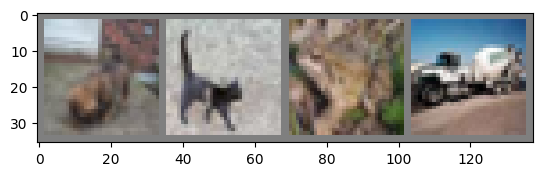

dog   cat   frog  truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### wandb

In [4]:
wandb.init(project="optimization-for-ML")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: stupidmoewe (stupid-moewe). Use `wandb login --relogin` to force relogin


# Training

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def train(net, trainloader, criterion, optimizer, epochs=2, device='cpu'):
    losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            # Log loss and learning rate
            wandb.log({"loss": loss.item(), "lr": optimizer.param_groups[0]['lr']})

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return losses

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
device = torch.device('cpu')

In [8]:
def train_with_optimizer(optimizer_name, trainloader, layer_wise=False, device='cpu', lr=0.001):
    net = Net().to(device)
    net.train()

    # Use learning rate from wandb config
    lr = wandb.config.learning_rate

    if optimizer_name == "sgd":
        optimizer = optim.SGD
    elif optimizer_name == "adam":
        optimizer = optim.Adam
    elif optimizer_name == "adagrad":
        optimizer = optim.Adagrad
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    if layer_wise:
        optimizer = optimizer([
            {'params': net.conv1.parameters()},
            {'params': net.conv2.parameters()},
            {'params': net.fc1.parameters()},
            {'params': net.fc2.parameters()},
            {'params': net.fc3.parameters()}
        ], lr=lr)
    else:
        optimizer = optimizer(net.parameters(), lr=lr)

    losses = train(net, trainloader, criterion, optimizer, device=device)
    return net, losses

In [9]:
sweep_config = {
    'method': 'bayes',  # or 'random', 'grid'
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'optimizer': {
            'values': ['sgd', 'adam', 'adagrad']
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.1
        }
    }
}

In [10]:
sweep_id = wandb.sweep(sweep_config)

def sweep_train():
    with wandb.init():
        config = wandb.config
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
        criterion = nn.CrossEntropyLoss()
        train_with_optimizer(config.optimizer, trainloader, layer_wise=False, device='cpu')

wandb.agent(sweep_id, function=sweep_train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: htvx96h1
Sweep URL: https://wandb.ai/stupid-moewe/uncategorized/sweeps/htvx96h1
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: 3nn5txgc with config:
wandb: 	learning_rate: 0.08969952112110884
wandb: 	optimizer: adagrad


[1,  2000] loss: 2.228
[1,  4000] loss: 1.799
[1,  6000] loss: 1.690
[1,  8000] loss: 1.624
[1, 10000] loss: 1.614
[1, 12000] loss: 1.560
[2,  2000] loss: 1.520
[2,  4000] loss: 1.496
[2,  6000] loss: 1.483
[2,  8000] loss: 1.457
[2, 10000] loss: 1.433
[2, 12000] loss: 1.422
Finished Training


loss,▆▄▄▄▄▃▄▃▆▅▃▃▄█▂▁▄▁▃▁▃▆▁▃█▅▅▄▃▂▅▂▂▃▁▄▅▅▄▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.87983
lr,0.0897


wandb: Agent Starting Run: ljjzmtwi with config:
wandb: 	learning_rate: 0.07988088112807902
wandb: 	optimizer: adagrad


[1,  2000] loss: 2.267
[1,  4000] loss: 1.880
[1,  6000] loss: 1.786
[1,  8000] loss: 1.735
[1, 10000] loss: 1.664
[1, 12000] loss: 1.623
[2,  2000] loss: 1.556
[2,  4000] loss: 1.533
[2,  6000] loss: 1.501
[2,  8000] loss: 1.496
[2, 10000] loss: 1.472
[2, 12000] loss: 1.447
Finished Training


loss,▆▆▅█▄▅▅▆▅█▃▃▅▆▄▅▂▄▄▅▃▂▃▃▁▃▅▄▃▄▄▂▄▅▄▅▃▃▃▆
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.08044
lr,0.07988


wandb: Agent Starting Run: 6go1hqbv with config:
wandb: 	learning_rate: 0.04598048179564303
wandb: 	optimizer: sgd


[1,  2000] loss: 2.010
[1,  4000] loss: 1.746
[1,  6000] loss: 1.673
[1,  8000] loss: 1.647
[1, 10000] loss: 1.630
[1, 12000] loss: 1.594
[2,  2000] loss: 1.559
[2,  4000] loss: 1.560
[2,  6000] loss: 1.562
[2,  8000] loss: 1.580
[2, 10000] loss: 1.547
[2, 12000] loss: 1.567
Finished Training


loss,▇▆█▄█▄▃▇▁▅▆▆▄▅▄▅▄▃▄▄▃▅▆▁▃▃▆▂▁▄▇▁▃▅▃▂▃▂▃▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.02761
lr,0.04598


wandb: Agent Starting Run: 05qphsmk with config:
wandb: 	learning_rate: 0.09333516500724652
wandb: 	optimizer: sgd


[1,  2000] loss: 2.081
[1,  4000] loss: 1.955
[1,  6000] loss: 1.907
[1,  8000] loss: 1.910
[1, 10000] loss: 1.939
[1, 12000] loss: 1.938
[2,  2000] loss: 1.915
[2,  4000] loss: 1.931
[2,  6000] loss: 1.980
[2,  8000] loss: 1.960
[2, 10000] loss: 1.959
[2, 12000] loss: 1.989
Finished Training


loss,▃▄▃▂█▃▃▅▃▂▂▃▃▂▃▆▂▄▃▄▃▃▃▁▃▂▄▃▅▃▄▃▃▃▃▄▂▄▂▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,2.44402
lr,0.09334


wandb: Agent Starting Run: aokblas2 with config:
wandb: 	learning_rate: 0.0017743237286650137
wandb: 	optimizer: adam


[1,  2000] loss: 1.915
[1,  4000] loss: 1.636
[1,  6000] loss: 1.571
[1,  8000] loss: 1.539
[1, 10000] loss: 1.481
[1, 12000] loss: 1.462
[2,  2000] loss: 1.405
[2,  4000] loss: 1.414
[2,  6000] loss: 1.391
[2,  8000] loss: 1.382
[2, 10000] loss: 1.352
[2, 12000] loss: 1.358
Finished Training


loss,▇▆▆█▃▆▆▄▆▅▂▅▂▃▄▃▄▅▄▅▃▄▆▃▂▅▄▅▅▄▂▁▃▅▄▁▁▂▆▄
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.42148
lr,0.00177


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8axc7yqx with config:
wandb: 	learning_rate: 0.0483528880360491
wandb: 	optimizer: adam


[1,  2000] loss: 2.333
[1,  4000] loss: 2.322
[1,  6000] loss: 2.320
[1,  8000] loss: 2.320
[1, 10000] loss: 2.320
[1, 12000] loss: 2.320
[2,  2000] loss: 2.320
[2,  4000] loss: 2.322
[2,  6000] loss: 2.321
[2,  8000] loss: 2.322
[2, 10000] loss: 2.321
[2, 12000] loss: 2.320
Finished Training


loss,▇▄▅▅▆▅▃▂█▆▄▇▅▅▇▃▅▁▃▅▄▇▄▄▆▅▅▂▇▅▅▅▅▄▅▃▅▄▆▄
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,2.41747
lr,0.04835


wandb: Agent Starting Run: 4uj09z5f with config:
wandb: 	learning_rate: 0.00775677563888795
wandb: 	optimizer: sgd


[1,  2000] loss: 2.236
[1,  4000] loss: 1.915
[1,  6000] loss: 1.744
[1,  8000] loss: 1.632
[1, 10000] loss: 1.541
[1, 12000] loss: 1.496
[2,  2000] loss: 1.432
[2,  4000] loss: 1.397
[2,  6000] loss: 1.366
[2,  8000] loss: 1.337
[2, 10000] loss: 1.319
[2, 12000] loss: 1.291
Finished Training


loss,▆▆▆▄▇▃▅▅▅▇▆▃▆█▂▃▅▄▄▅▂▂▄▂▅▃▄▂▂▂▂▃▃▄▁▂▃▂▄▃
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.85077
lr,0.00776


wandb: Agent Starting Run: 1dlcy5fh with config:
wandb: 	learning_rate: 0.02954048599688555
wandb: 	optimizer: adam


[1,  2000] loss: 2.324
[1,  4000] loss: 2.314
[1,  6000] loss: 2.312
[1,  8000] loss: 2.313
[1, 10000] loss: 2.313
[1, 12000] loss: 2.313
[2,  2000] loss: 2.315
[2,  4000] loss: 2.314
[2,  6000] loss: 2.314
[2,  8000] loss: 2.314
[2, 10000] loss: 2.313
[2, 12000] loss: 2.314
Finished Training


loss,▃▅▃█▂▂▆▃▅▂▅▄▂▃▁▆▃▆▃▅▄▆▄▇▅▃▁▄▃▃▂▅▄▅▃▄▃▆▃▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,2.25495
lr,0.02954


wandb: Agent Starting Run: fwv9j55d with config:
wandb: 	learning_rate: 0.05105494487752061
wandb: 	optimizer: adam


[1,  2000] loss: 2.346
[1,  4000] loss: 2.322
[1,  6000] loss: 2.320


wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x14c8b1540>> (for post_run_cell), with arguments args (<ExecutionResult object at 14c8b1b10, execution_count=10 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 14c8b1a20, raw_cell="sweep_id = wandb.sweep(sweep_config)

def sweep_tr.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/teframartin/EPFL_Cours/MA4/OptiMlForever/index-test.ipynb#X21sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

### SGD

In [ ]:
def train_with_optimizer(optimizer_name, trainloader, layer_wise=False, device='cpu', lr=0.001):
    net = Net().to(device)
    net.train()

    if optimizer_name == "sgd":
        optimizer = optim.SGD
    elif optimizer_name == "adam":
        optimizer = optim.Adam
    elif optimizer_name == "adagrad":
        optimizer = optim.Adagrad
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    if layer_wise:
        optimizer = optimizer([
            {'params': net.conv1.parameters()},
            {'params': net.conv2.parameters()},
            {'params': net.fc1.parameters()},
            {'params': net.fc2.parameters()},
            {'params': net.fc3.parameters()}
        ], lr=lr)
    else:
        optimizer = optimizer(net.parameters(), lr=lr)

    losses = train(net, trainloader, criterion, optimizer, device=device)
    return net, losses

In [ ]:
adagrad_lrs= [0.0897,0.07988 ]
sgd_lrs = [0.04598, 0.09334]
adam_lrs = [0.00177, 0.04835]

In [8]:
# SGD
net_sgd, losses_sgd = train_with_optimizer(optim.SGD, trainloader, device=device, lr=0.001)
net_sgd_lw, losses_sgd_lw = train_with_optimizer(optim.SGD, trainloader, layer_wise=True, device=device, lr=0.001)

# Adam
net_adam, losses_adam = train_with_optimizer(optim.Adam, trainloader, device=device, lr=0.001)
net_adam_lw, losses_adam_lw = train_with_optimizer(optim.Adam, trainloader, layer_wise=True, device=device, lr=0.001)

# AdaGrad
net_adagrad, losses_adagrad = train_with_optimizer(optim.Adagrad, trainloader, device=device, lr=0.001)
net_adagrad_lw, losses_adagrad_lw = train_with_optimizer(optim.Adagrad, trainloader, layer_wise=True, device=device, lr=0.001)

[1,  2000] loss: 2.303
[1,  4000] loss: 2.298
[1,  6000] loss: 2.289
[1,  8000] loss: 2.262
[1, 10000] loss: 2.190
[1, 12000] loss: 2.118
[2,  2000] loss: 2.028
[2,  4000] loss: 1.972
[2,  6000] loss: 1.903
[2,  8000] loss: 1.865
[2, 10000] loss: 1.803
[2, 12000] loss: 1.745
Finished Training
[1,  2000] loss: 2.304
[1,  4000] loss: 2.302
[1,  6000] loss: 2.301
[1,  8000] loss: 2.299
[1, 10000] loss: 2.294
[1, 12000] loss: 2.288
[2,  2000] loss: 2.255
[2,  4000] loss: 2.137
[2,  6000] loss: 1.993
[2,  8000] loss: 1.930
[2, 10000] loss: 1.874
[2, 12000] loss: 1.818
Finished Training
[1,  2000] loss: 1.855
[1,  4000] loss: 1.621
[1,  6000] loss: 1.519
[1,  8000] loss: 1.483
[1, 10000] loss: 1.437
[1, 12000] loss: 1.416
[2,  2000] loss: 1.342
[2,  4000] loss: 1.314
[2,  6000] loss: 1.319
[2,  8000] loss: 1.303
[2, 10000] loss: 1.268
[2, 12000] loss: 1.262
Finished Training
[1,  2000] loss: 1.816
[1,  4000] loss: 1.594
[1,  6000] loss: 1.510
[1,  8000] loss: 1.450
[1, 10000] loss: 1.429
[1,

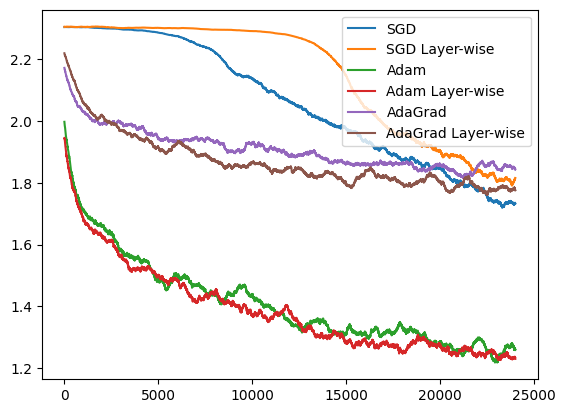

In [9]:
moving_average_sgd = np.convolve(losses_sgd, np.ones(1000)/1000, mode='valid')
moving_average_sgd_lw = np.convolve(losses_sgd_lw, np.ones(1000)/1000, mode='valid')
moving_average_adam = np.convolve(losses_adam, np.ones(1000)/1000, mode='valid')
moving_average_adam_lw = np.convolve(losses_adam_lw, np.ones(1000)/1000, mode='valid')
moving_average_adagrad = np.convolve(losses_adagrad, np.ones(1000)/1000, mode='valid')
moving_average_adagrad_lw = np.convolve(losses_adagrad_lw, np.ones(1000)/1000, mode='valid')

plt.plot(moving_average_sgd, label='SGD')
plt.plot(moving_average_sgd_lw, label='SGD Layer-wise')
plt.plot(moving_average_adam, label='Adam')
plt.plot(moving_average_adam_lw, label='Adam Layer-wise')
plt.plot(moving_average_adagrad, label='AdaGrad')
plt.plot(moving_average_adagrad_lw, label='AdaGrad Layer-wise')
plt.legend()
plt.show()
